In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline 
sns.set(color_codes=True)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import  metrics 
from sklearn.model_selection import cross_validate, GridSearchCV

In [2]:
trainset = pd.read_csv('Data\credit_card_default_train.csv', index_col='Client_ID' )
testset = pd.read_csv('Data\credit_card_default_test.csv', index_col='Client_ID' )

In [3]:
trainset['Balance_Limit_V1'] = trainset['Balance_Limit_V1'].replace({'K': '*1e3', 'M': '*1e6'}, regex=True).map(pd.eval).astype(int)
testset['Balance_Limit_V1'] = testset['Balance_Limit_V1'].replace({'K': '*1e3', 'M': '*1e6'}, regex=True).map(pd.eval).astype(int)

In [4]:
encode_columns = ['AGE']
encode_df = trainset[encode_columns]
encode_df = encode_df.astype('str')
le = LabelEncoder()
encode_df = encode_df.apply(le.fit_transform)
score_encode_drop = trainset.drop(encode_columns, axis = 1)
score_encode = pd.concat([score_encode_drop, encode_df], axis = 1)

In [5]:
encode_df_test = testset[encode_columns]
encode_df_test = encode_df_test.astype('str')
encode_df_test = encode_df_test.apply(le.fit_transform)
score_encode_drop_test = testset.drop(encode_columns, axis = 1)
score_encode_test = pd.concat([score_encode_drop_test, encode_df_test], axis = 1)


In [6]:
onehot_columns =  ['MARITAL_STATUS', 'EDUCATION_STATUS', 'Gender', 'PAY_JULY','PAY_AUG','PAY_SEP','PAY_OCT','PAY_NOV','PAY_DEC']
onehot_df = score_encode[onehot_columns]
onehot_df = pd.get_dummies(onehot_df, columns = onehot_columns)
score_onehot_drop = score_encode.drop(onehot_columns, axis = 1)
score_onehot = pd.concat([score_onehot_drop, onehot_df], axis = 1)

In [7]:
onehot_df_test = score_encode_test[onehot_columns]
onehot_df_test = pd.get_dummies(onehot_df_test, columns = onehot_columns)
score_onehot_drop_test = score_encode_test.drop(onehot_columns, axis = 1)
score_onehot_test = pd.concat([score_onehot_drop_test, onehot_df_test], axis = 1)

In [8]:
New = score_onehot.drop(['Gender_M', 'MARITAL_STATUS_Other','Gender_F','EDUCATION_STATUS_Other','EDUCATION_STATUS_High School','EDUCATION_STATUS_Graduate','MARITAL_STATUS_Single','AGE'], axis=1)

target = 'NEXT_MONTH_DEFAULT'
IDcol = 'Client_ID'
predictors = [x for x in score_onehot.columns if x not in [target, IDcol]]

In [9]:
train_all, test_all = train_test_split(score_onehot, test_size=0.30, random_state=42)

In [10]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['NEXT_MONTH_DEFAULT'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['NEXT_MONTH_DEFAULT'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['NEXT_MONTH_DEFAULT'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

    return alg


Model Report
Accuracy : 0.8698
AUC Score (Train): 0.904556


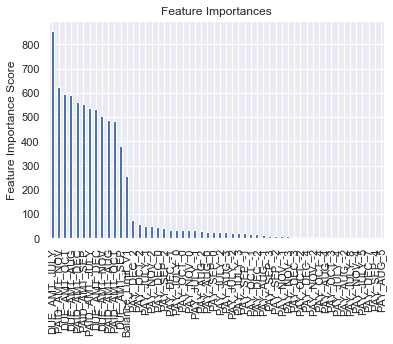

In [11]:
predictorsnew = [x for x in New.columns if x not in [target, IDcol]]
xgb_new = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=10,
 min_child_weight=1,
 gamma=0.4,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
model_2 = modelfit(xgb_new, New, predictorsnew)